In [ ]:
import torch
from transformers import AutoModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from transformers import GPTNeoXModel, GPTNeoXConfig
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
import random

In [ ]:
# Вначале для удобства лучше все тестировать на 70M модели,
# но для итоговой презентации наверное нужно будет все прогнать на 2.7 B модели
model_name = "EleutherAI/pythia-410M"

checkpoint_steps = [0] + [2**i for i in range(1, 10)] + list(range(1000, 143001, 1000))
branch_names = [f"step{step}" for step in checkpoint_steps]

# Посмотрим как выглядит архитектура модели и как её доставать
model = AutoModel.from_pretrained(model_name, revision=branch_names[-1], trust_remote_code=True)
model

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Select 25 intermediate layers
layer_indices = list(range(0, len(model.layers)))  # Total layers
selected_layers = random.sample(layer_indices, 20)

dense_h_to_4h_weights = []
dense_4h_to_h_weights = []

for idx in selected_layers:
    layer = model.layers[idx]
    dense_h_to_4h = layer.mlp.dense_h_to_4h.weight.data.cpu().numpy()  # Shape: (10240, 2560)
    dense_4h_to_h = layer.mlp.dense_4h_to_h.weight.data.cpu().numpy()  # Shape: (2560, 10240)
    dense_h_to_4h_weights.append(dense_h_to_4h)
    dense_4h_to_h_weights.append(dense_4h_to_h)

In [ ]:
from sklearn.preprocessing import StandardScaler

class WeightsDataset(Dataset):
    def __init__(self, h_to_4h_weights, h_4_to_h_weights):
        self.X = []
        self.Y = []
        for h_to_4h, h4_to_h in zip(h_to_4h_weights, h_4_to_h_weights):
            # Flatten the weights
            X_flat = h_to_4h
            Y_flat = h4_to_h.T
            self.X.extend(X_flat)
            self.Y.extend(Y_flat)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.Y[idx], dtype=torch.float32)

dataset = WeightsDataset(dense_h_to_4h_weights, dense_4h_to_h_weights)
scaler = StandardScaler()
dataset.X = scaler.fit_transform(dataset.X)
dataset.Y = scaler.fit_transform(dataset.Y)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, input_size)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define input and output sizes
input_size = dense_h_to_4h_weights[0].size  # (10240, 2560) flattened
input_size = 1024
output_size = 1024

# Initialize the model
model_nn = SimpleNN(input_size, output_size)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_nn.to(device)

SimpleNN(
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=1024, bias=True)
)

In [ ]:
batch_size = 500

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_nn.parameters(), lr=1e-4)

In [ ]:
num_epochs = 100
train_losses = []
test_losses = []
best_ev = -np.inf
ev_scores = []

for epoch in range(num_epochs):
    model_nn.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model_nn(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / train_size
    train_losses.append(epoch_loss)

    # Evaluate on test set
    model_nn.eval()
    test_running_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model_nn(inputs)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item() * inputs.size(0)

            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    test_loss = test_running_loss / test_size
    test_losses.append(test_loss)

    # Calculate explained variance
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    ev = explained_variance_score(all_targets, all_preds, multioutput='uniform_average')
    ev_scores.append(ev)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Explained Variance: {ev:.4f}')

    if ev > best_ev:
        best_ev = ev
        # Optionally save the best model
        torch.save(model_nn.state_dict(), 'best_model.pth')

Epoch 1/100, Train Loss: 1.0290, Test Loss: 1.0216, Explained Variance: -0.0200
Epoch 2/100, Train Loss: 1.0122, Test Loss: 1.0121, Explained Variance: -0.0106
Epoch 3/100, Train Loss: 1.0027, Test Loss: 1.0062, Explained Variance: -0.0047
Epoch 4/100, Train Loss: 0.9962, Test Loss: 1.0021, Explained Variance: -0.0006
Epoch 5/100, Train Loss: 0.9912, Test Loss: 0.9990, Explained Variance: 0.0025
Epoch 6/100, Train Loss: 0.9871, Test Loss: 0.9964, Explained Variance: 0.0051
Epoch 7/100, Train Loss: 0.9834, Test Loss: 0.9943, Explained Variance: 0.0072
Epoch 8/100, Train Loss: 0.9801, Test Loss: 0.9924, Explained Variance: 0.0091
Epoch 9/100, Train Loss: 0.9770, Test Loss: 0.9908, Explained Variance: 0.0108
Epoch 10/100, Train Loss: 0.9742, Test Loss: 0.9893, Explained Variance: 0.0122
Epoch 11/100, Train Loss: 0.9715, Test Loss: 0.9881, Explained Variance: 0.0134
Epoch 12/100, Train Loss: 0.9691, Test Loss: 0.9871, Explained Variance: 0.0145
Epoch 13/100, Train Loss: 0.9668, Test Loss: 

KeyboardInterrupt: 

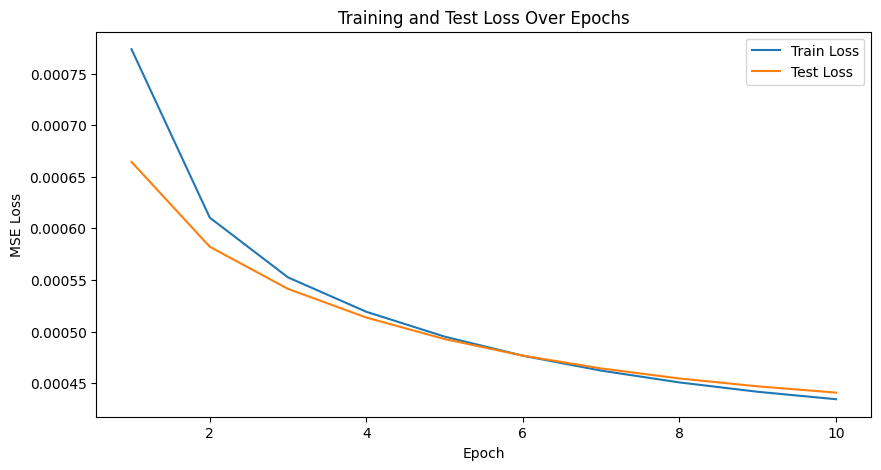

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

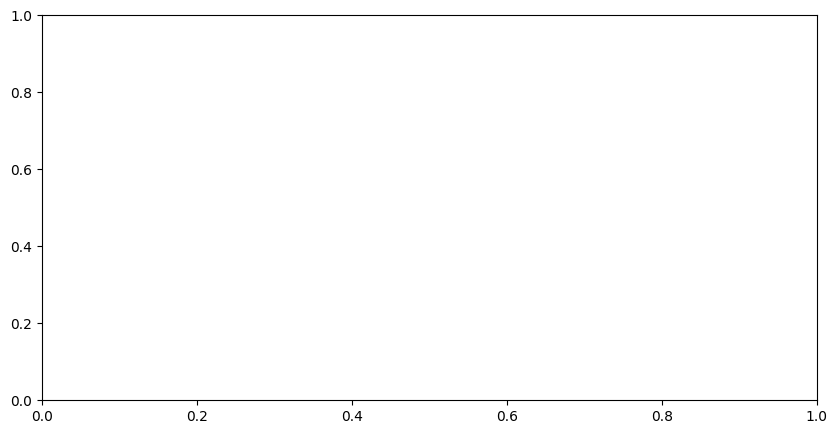

In [ ]:
# Add this before the training loop
ev_scores = []

# Inside the training loop, after calculating ev
ev_scores.append(ev)

# After training, plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), ev_scores, label='Explained Variance')
plt.xlabel('Epoch')
plt.ylabel('Explained Variance')
plt.title('Explained Variance Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Load the best model
model_nn.load_state_dict(torch.load('best_model.pth'))
model_nn.eval()

# Final evaluation on test set
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model_nn(inputs)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)
final_ev = explained_variance_score(all_targets, all_preds, multioutput='uniform_average')
print(f'Final Explained Variance on Test Set: {final_ev:.4f}')